In [ ]:
# Working through learnpytorch.io examples to reinforce concepts.

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=99)

In [2]:
print(f'First 5 X features:\n{X[:5]}')
print(f'First 5 y labels:\n{y[:5]}')


First 5 X features:
[[ 0.14424115 -0.80407463]
 [ 0.81931171 -0.17417491]
 [ 0.24547016  0.97564023]
 [ 0.18750411  0.83405486]
 [ 0.14550415  0.99650235]]
First 5 y lables:
[1 1 0 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})

circles.head()

,X1,X2,label
0,0.144241,-0.804075,1
1,0.819312,-0.174175,1
2,0.245470,0.975640,0
3,0.187504,0.834055,1
4,0.145504,0.996502,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

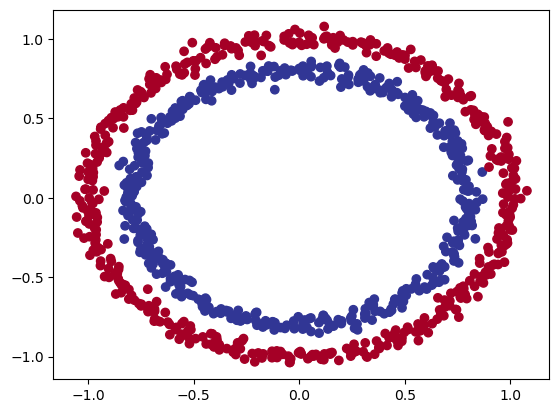

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')



Values for one sample of X: [ 0.14424115 -0.80407463] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [10]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.1442, -0.8041],
         [ 0.8193, -0.1742],
         [ 0.2455,  0.9756],
         [ 0.1875,  0.8341],
         [ 0.1455,  0.9965]]),
 tensor([1., 1., 0., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=99)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Data is ready - Now Build Model

In [13]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
#subclass nn.module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# alternatively use sequential model

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
#make predictions with no training
untrained_preds = model_0(X_test.to(device))

print(f'\nFirst 10 predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 test labels:\n{y_test[:10]}')


First 10 predictions:
tensor([[-0.1846],
        [ 0.1321],
        [-0.0765],
        [ 0.6056],
        [ 0.2777],
        [ 0.6059],
        [ 0.1112],
        [ 0.5776],
        [-0.1151],
        [ 0.0839]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 1.])


In [19]:
#create a loss function for training
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [21]:
# create accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return(acc)

In [22]:
torch.manual_seed(99)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    #forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.70571, Accuracy: 53.12% | Test Loss: 0.73159, Test acc: 48.00%
Epoch: 10 | Loss: 0.70145, Accuracy: 52.25% | Test Loss: 0.72233, Test acc: 48.00%
Epoch: 20 | Loss: 0.69875, Accuracy: 52.50% | Test Loss: 0.71640, Test acc: 48.00%
Epoch: 30 | Loss: 0.69693, Accuracy: 52.88% | Test Loss: 0.71238, Test acc: 48.00%
Epoch: 40 | Loss: 0.69566, Accuracy: 53.00% | Test Loss: 0.70955, Test acc: 48.50%
Epoch: 50 | Loss: 0.69477, Accuracy: 52.75% | Test Loss: 0.70749, Test acc: 47.00%
Epoch: 60 | Loss: 0.69412, Accuracy: 53.00% | Test Loss: 0.70595, Test acc: 47.50%
Epoch: 70 | Loss: 0.69366, Accuracy: 53.62% | Test Loss: 0.70479, Test acc: 46.00%
Epoch: 80 | Loss: 0.69331, Accuracy: 54.50% | Test Loss: 0.70389, Test acc: 46.50%
Epoch: 90 | Loss: 0.69306, Accuracy: 54.37% | Test Loss: 0.70319, Test acc: 47.00%


In [23]:
# model isn't learning anything
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper functions')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

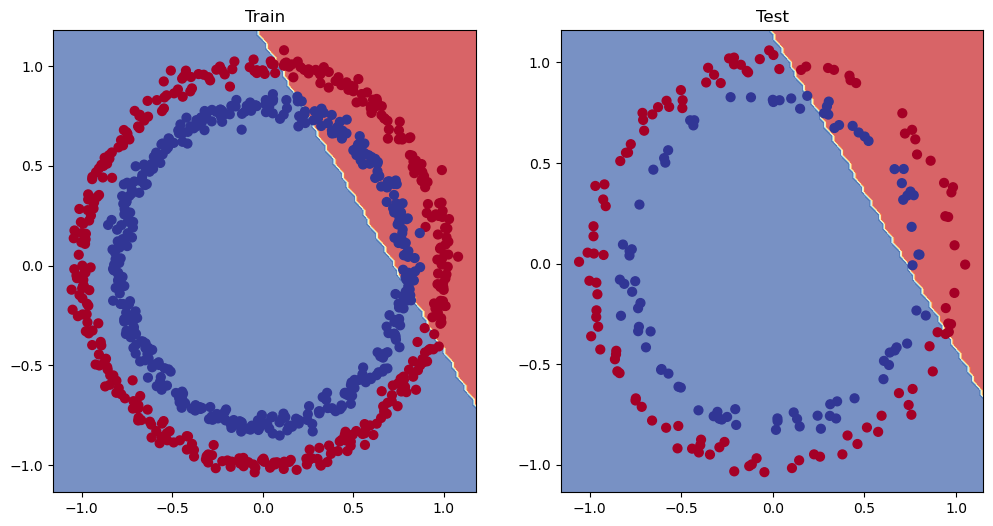

In [24]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)